In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from scipy import stats
import statsmodels.api as sm
import math
import re
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sys
import pandas.core.algorithms as algos
pd.pandas.set_option('display.max_columns',None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train=pd.read_csv('/content/drive/MyDrive/machine learning practice/trainingset/fake news train.csv')

In [3]:
train.head()  # label에 1이면 스팸 0이면 아님

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
train.shape

(20800, 5)

In [5]:
features=[i for i  in train.columns if i not in ['label']]  # ['id', 'title', 'author', 'text']로 써도 상관은 없음

In [6]:
features

['id', 'title', 'author', 'text']

In [7]:
train.info()  # 각 항목의 데이터 타입을 알아낸다

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [8]:
train.fillna('unavailable',inplace=True)

In [9]:
test=pd.read_csv('/content/drive/MyDrive/machine learning practice/trainingset/fake news test.csv')

In [10]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [11]:
test.info() # 5200개의 테스트 데이터이지만 비어있는 부분은 NAN으로 빈칸이여서 개수가 부족

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
dtypes: int64(1), object(3)
memory usage: 162.6+ KB


In [12]:
test.fillna('unavailable',inplace=True)

In [13]:
df=pd.concat([train,test],axis='rows')

In [14]:
df.info() # 테스트 데이터에는 정답데이터인 레이블이 없기때문에 레이블칸에 5200개가 부족하다

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26000 entries, 0 to 5199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      26000 non-null  int64  
 1   title   26000 non-null  object 
 2   author  26000 non-null  object 
 3   text    26000 non-null  object 
 4   label   20800 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.2+ MB


In [15]:
df['comb']=df['author']+"_"+df['title']#+df['text']      # Combined all the features 

In [16]:
df['comb']  # df['comb']에 작가, 제목 합친 데이터를 저장

0       Darrell Lucus_House Dem Aide: We Didn’t Even S...
1       Daniel J. Flynn_FLYNN: Hillary Clinton, Big Wo...
2       Consortiumnews.com_Why the Truth Might Get You...
3       Jessica Purkiss_15 Civilians Killed In Single ...
4       Howard Portnoy_Iranian woman jailed for fictio...
                              ...                        
5195    Jody Rosen_The Bangladeshi Traffic Jam That Ne...
5196    Sheryl Gay Stolberg_John Kasich Signs One Abor...
5197    Mike McPhate_California Today: What, Exactly, ...
5198    unavailable_300 US Marines To Be Deployed To R...
5199    Teddy Wayne_Awkward Sex, Onscreen and Off - Th...
Name: comb, Length: 26000, dtype: object

In [17]:
import nltk
nltk.download('stopwords')  # 단어 구별 리스트인듯..?
nltk.download('wordnet')  # 유사 단어 파악, 단어의 유사도 계산할 수 있는 라이브러리
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [18]:
import string
import re
string.punctuation  # 느낌표, 물음표같은 특수문자

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
wordnet=WordNetLemmatizer() # 사전형 단어를 추출을 위한 도구 즉 예를 들어, am, are, is는 서로 다른 스펠링이지만 그 뿌리 단어는 be라고 볼 수 있다. 이때, 이 단어들의 표제어는 be이다.
stemmer=PorterStemmer() # 단어를 단순화시키는 작업 예를 들면 lovely->love로 변환해준다
def clean(text):
  # text="".join([char for char in text if char not in string.punctuation])
  text="".join([re.sub('[^a-zA-Z]',' ',char) for char in text ])
  text=text.lower()
  text=text.split()
  text=[stemmer.stem(word) for word in text if word not in set(stopwords.words("english"))]
  text=" ".join(text)
  return text

In [20]:
df['comb']=df['comb'].apply(clean)

In [21]:
df.head()

,id,title,author,text,label,comb
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1.0,darrel lucu hous dem aid even see comey letter...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0.0,daniel j flynn flynn hillari clinton big woman...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1.0,consortiumnew com truth might get fire
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1.0,jessica purkiss civilian kill singl us airstri...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1.0,howard portnoy iranian woman jail fiction unpu...


In [22]:
import tensorflow
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

In [23]:
voc_size=10000   # Vocabulary size

In [24]:
title=df['comb']
title[0]

0    darrel lucu hous dem aid even see comey letter...
0    david streitfeld specter trump loosen tongu pu...
Name: comb, dtype: object

In [25]:
one_hot_r=[one_hot(words, voc_size) for words in title]

In [26]:
one_hot_r[0:2]

[[9027, 8787, 2375, 4628, 8673, 2168, 7916, 6979, 7711, 5493, 2450, 1069],
 [9860, 5330, 3107, 3107, 5044, 8772, 6953, 5764, 1111, 1972]]

In [27]:
# embed 
sent_len=30
embedded_docs=pad_sequences(one_hot_r,padding='post',maxlen=sent_len)

In [28]:
embedded_docs[:10]

array([[9027, 8787, 2375, 4628, 8673, 2168, 7916, 6979, 7711, 5493, 2450,
        1069,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [9860, 5330, 3107, 3107, 5044, 8772, 6953, 5764, 1111, 1972,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [9595, 4762, 9051, 4742, 7218, 3920,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [3526, 4310, 9196, 8731, 7888, 1966, 1801, 4507,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [6142, 9552, 5896, 5764, 4715, 8484, 2316, 5571, 5764, 9626, 9789,
        9006,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 

In [29]:
sgd=tensorflow.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6,momentum=0.9, nesterov=True)
rms = tensorflow.keras.optimizers.RMSprop()
nadam=tensorflow.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam"
)

In [30]:
embedding_vector_features=50
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_len))
# model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(100)))  # used Bidirectional LSTM
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='nadam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            500000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              120800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 621,001
Trainable params: 621,001
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
len(embedded_docs)

26000

In [32]:
X=embedded_docs[:train.shape[0]]
y=df['label'][:train.shape[0]]
x_test=embedded_docs[train.shape[0]:]

In [33]:
X_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
model.fit(X_train,y_train,validation_data=(x_valid,y_valid),epochs=25,batch_size=124)

Epoch 1/25
135/135 [==============================] - 22s 128ms/step - loss: 0.2178 - accuracy: 0.8926 - val_loss: 0.0478 - val_accuracy: 0.9856
Epoch 2/25
135/135 [==============================] - 16s 120ms/step - loss: 0.0181 - accuracy: 0.9952 - val_loss: 0.0638 - val_accuracy: 0.9805
Epoch 3/25
135/135 [==============================] - 16s 118ms/step - loss: 0.0079 - accuracy: 0.9981 - val_loss: 0.0477 - val_accuracy: 0.9856
Epoch 4/25
135/135 [==============================] - 16s 116ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.0715 - val_accuracy: 0.9832
Epoch 5/25
135/135 [==============================] - 16s 117ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.0646 - val_accuracy: 0.9863
Epoch 6/25
135/135 [==============================] - 16s 116ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0628 - val_accuracy: 0.9875
Epoch 7/25
135/135 [==============================] - 16s 116ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.0720 - val_ac

In [35]:
y_pred_prob=np.array(model.predict(X_train))[:,0]
y_pred_valid=np.array(model.predict(x_valid))[:,0]
y_pred=np.array(model.predict(x_test))[:,0]

In [36]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred_valid)

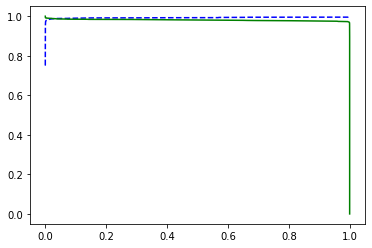

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
[...]
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [38]:
def cutoff_youdens_j(fpr,tpr,thresholds):
  a = tpr-fpr
  b = sorted(zip(a,thresholds))
  return b[-1][1] 

In [39]:
fpr, tpr, threshold = metrics.roc_curve(y_valid, y_pred_valid)

In [40]:
cutoff = cutoff_youdens_j(fpr, tpr, threshold)

In [41]:
A=[]
B=[]
C=[]
for i in range(len(threshold)):
  predicted = pd.DataFrame()
  predicted["label"] = y_pred_prob
  predicted["label"] = np.where(predicted["label"] > float(threshold[i]), 1, 0)
  pred_valid = pd.DataFrame()
  pred_valid["label"] = y_pred_valid
  pred_valid["label"] = np.where(pred_valid["label"] > float(threshold[i]), 1, 0)
  A.append(metrics.accuracy_score(y_train, predicted))
  B.append(metrics.accuracy_score(y_valid, pred_valid))
  C.append(threshold[i])
acc=pd.DataFrame(C,columns=['threshold'])
acc['train_acc']=A
acc['test_acc']=B
acc.sort_values(by='test_acc',ascending=False,inplace=True)

In [41]:
# cutoff=acc.iloc[0,0]
# cutoff

In [42]:
predicted = pd.DataFrame()
predicted["label"] = y_pred_prob
predicted["label"] = np.where(predicted["label"] > float(cutoff), 1, 0)
predicted

pred_valid = pd.DataFrame()
pred_valid["label"] = y_pred_valid
pred_valid["label"] = np.where(pred_valid["label"] > float(cutoff), 1, 0)
pred_valid

predictions = pd.DataFrame()
predictions['label'] = y_pred
predictions['label'] = np.where(predictions['label'] > float(cutoff), 1, 0)
predictions

,label
0,0
1,1
2,1
3,0
4,1
...,...
5195,0
5196,0
5197,0
5198,1


In [43]:
from sklearn.metrics import roc_auc_score

In [44]:
conf_matrix = metrics.confusion_matrix(y_train, predicted)
print(conf_matrix)
acc_train = metrics.accuracy_score(y_train, predicted)
print(acc_train)
precision_train = metrics.precision_score(y_train, predicted)
print(precision_train)
sensitivity_train = metrics.recall_score(y_train, predicted)
print(sensitivity_train)
specificity_train = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
print(specificity_train)
roc_auc_score(y_train, predicted)

[[8255    0]
 [   0 8385]]
1.0
1.0
1.0
1.0


1.0

In [45]:
conf_matrix = metrics.confusion_matrix(y_valid, pred_valid)
print(conf_matrix)

acc_train = metrics.accuracy_score(y_valid, pred_valid)
print(acc_train)
precision_train = metrics.precision_score(y_valid, pred_valid)
print(precision_train)
sensitivity_train = metrics.recall_score(y_valid, pred_valid)
print(sensitivity_train)
specificity_train = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
print(specificity_train)
roc_auc_score(y_valid, pred_valid)

[[2106   26]
 [  23 2005]]
0.9882211538461538
0.9871984244214672
0.9886587771203156
0.9878048780487805


0.9882318275845481

In [46]:
from sklearn.metrics import f1_score
print(f1_score(y_train, predicted,average='macro'))
f1_score(y_valid, pred_valid,average='macro')

1.0


0.9882142065644164

In [47]:
submit=pd.read_csv('/content/drive/MyDrive/machine learning practice/trainingset/fake news submit.csv')

In [48]:
submit.head()

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


In [49]:
submit['label']=predictions['label']

In [50]:
submit.to_csv('sub23',index=False)